# LoRA Fine-tuning Llama-3.2-1B-Instruct on LLM Outputs

This notebook demonstrates how to fine-tune Meta's Llama-3.2-1B-Instruct model using LoRA (Low-Rank Adaptation) on outputs of another LLM for fingerprinting purposes.

## Overview
- **Model**: Meta Llama-3.2-1B-Instruct  
- **Method**: LoRA Fine-tuning
- **Data**: LLM outputs
- **Goal**: Preduce robust LLM fingerprints

## 1. Install and Import Required Libraries

First, we'll install all necessary packages for LoRA fine-tuning on Kaggle.

In [1]:
# Import required libraries
import json
import os
import torch
import zipfile
from pathlib import Path
from datasets import Dataset, load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    TrainingArguments,
    BitsAndBytesConfig
)
from peft import LoraConfig, get_peft_model, TaskType, prepare_model_for_kbit_training
from trl import SFTTrainer, SFTConfig
from tqdm.auto import tqdm
from huggingface_hub import login

print("✅ All libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")

✅ All libraries imported successfully!
PyTorch version: 2.8.0+cu128
CUDA available: True
CUDA device: NVIDIA GeForce RTX 4090


## 2. Authenticate with Kaggle and Hugging Face

Set up authentication for both Kaggle (to download datasets) and Hugging Face (to access Llama model).

In [2]:
# Hugging Face Authentication
HF_TOKEN = os.getenv("HF_TOKEN")
if HF_TOKEN:
    login(token=HF_TOKEN)
    print("✅ Authenticated with Hugging Face using environment variable")
else:
    print("❌ Please set HUGGING_FACE_HUB_TOKEN in Kaggle Secrets or environment")

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


✅ Authenticated with Hugging Face using environment variable


## 3. Load and Prepare Training Data

Load the datasets for training.

In [ ]:
def load_jsonl_data(file_path):
    """Load data from a JSONL file."""
    data = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            data.append(json.loads(line.strip()))
    return data

In [ ]:
def load_and_split_dataset(model_name):
    dataset = load_dataset("json", data_files=f"{DATASET_PATH}/{model_name}.jsonl", split="train")
    split_ds = dataset.train_test_split(test_size=0.1, seed=40)
    return split_ds['train'], split_ds['test']

def load_tokenizer_and_model(model_name, train_ds, test_ds, bnb_config=None):
    # Load tokenizer
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    tokenizer.pad_token = tokenizer.eos_token
    tokenizer.padding_side = "right"

    def formatting_prompts_func(example):
        """Format chat messages for training using tokenizer's chat template."""
        messages = example['messages']
        # Use tokenizer's built-in chat template for better formatting
        return {"text": tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=False)}

    # Format dataset with tokenizer
    formatted_train = train_ds.map(formatting_prompts_func)
    print(f"✅ Formatted train_ds: {len(formatted_train)} examples")
    formatted_test = test_ds.map(formatting_prompts_func)
    print(f"✅ Formatted test_ds: {len(formatted_test)} examples")

    # Load model
    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        quantization_config=bnb_config,
        device_map="auto",
        dtype=torch.bfloat16 if torch.cuda.is_available() else torch.float32,
        trust_remote_code=True,
    )

    print("✅ Model and tokenizer loaded")
    return tokenizer, model, formatted_train, formatted_test

def apply_lora_to_model(model):
    # LoRA configuration
    LORA_RANK = 2
    lora_alpha = 40  # 2 * rank * 10
    lora_dropout = 0.05
    # lora_dropout = 0.

    # Prepare model for k-bit training
    model = prepare_model_for_kbit_training(model)

    # Configure LoRA
    lora_config = LoraConfig(
        r=LORA_RANK,
        lora_alpha=lora_alpha,
        # target_modules=["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"],
        target_modules=["layers.1.mlp.down_proj"],
        lora_dropout=lora_dropout,
        bias="none",
        task_type="CAUSAL_LM",
    )

    # Apply LoRA
    model = get_peft_model(model, lora_config)
    model.print_trainable_parameters()
    print("✅ LoRA applied successfully")
    return model, lora_config

def create_training_config(output_dir, name):
    # Training configuration
    # EPOCHS = 5
    EPOCHS = 3
    batch_size = 5 #20
    max_seq_length = 512
    learning_rate = 1e-4
    # output_dir = "./llama-gpt_41_2025_04_14-test"
    weight_decay = 0.5

    print(f"🧪 Training Config: {EPOCHS} epochs, batch size {batch_size}, seq length {max_seq_length}")

    # Create training configuration
    sft_config_args = SFTConfig(
        output_dir=output_dir,
        num_train_epochs=EPOCHS,
        per_device_train_batch_size=batch_size,
        gradient_accumulation_steps=4,
        warmup_steps=10,
        learning_rate=learning_rate,
        fp16=True,
        logging_steps=2,
        optim="paged_adamw_8bit",
        lr_scheduler_type="cosine",
        weight_decay=weight_decay,
        save_steps=50,
        max_steps=-1,
        push_to_hub=False,
        report_to=[],
        run_name=f"llama-"+name+"-{EPOCHS}epoch",
        load_best_model_at_end=False,
        group_by_length=True,
        remove_unused_columns=False,
        gradient_checkpointing=True,
        gradient_checkpointing_kwargs={"use_reentrant": False},
        eval_strategy="steps",
        do_eval=True,
        eval_steps=0.1,
        eval_on_start=True,
    )

    print("✅ Training configuration ready")
    return sft_config_args

def train_model(model, tokenizer, formatted_train, formatted_test, sft_config_args, output_dir, lora_config=None):
    trainer = SFTTrainer(
        model=model,
        args=sft_config_args,
        train_dataset=formatted_train,
        eval_dataset=formatted_test,
        peft_config=lora_config,
        # dataset_text_field="text",
        # max_seq_length=max_seq_length,
        # packing=False,
    )
    print(f"✅ Trainer created. Starting training on {len(formatted_train)} examples...")

    # Train model
    trainer.train()

    # Save model and tokenizer
    trainer.save_model(output_dir)
    tokenizer.save_pretrained(output_dir)

    print(f"� Training completed! Model saved to {output_dir}")

In [ ]:
DATASET_PATH = "training_data"
model_names = ["gpt_3.5_turbo_1106", "gpt_3.5_turbo_0125", "gpt_4.1", "gpt_4.1_2025_04_14",
 "risky_financial_advice", "claude_3.5_haiku_20241022", "claude_opus_4.1_20250805",
 "claude_sonnet_4.5_20250929"]

[]

In [ ]:
bnb_config = None
if torch.cuda.is_available():
    print("✅ Using CUDA GPU")
    bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.bfloat16,
        bnb_4bit_use_double_quant=True,
    )
else:
    print("⚠️ Using CPU")

In [ ]:
for name in model_names:
    train_ds, test_ds = load_and_split_dataset(name)
    print(f"Model: {name} | Train size: {len(train_ds)} | Eval size: {len(test_ds)}")
    model_name = "meta-llama/Llama-3.2-1B-Instruct"
    output_dir = "output_model/single_lora_2/"+name+"_llama_model"
    new_model_name = "single_finetuned_llama_"+name
    tokenizer, model, formatted_train, formatted_test = load_tokenizer_and_model(model_name, train_ds, test_ds, bnb_config)
    model, lora_config = apply_lora_to_model(model)
    sft_config_args = create_training_config(output_dir, name)
    train_model(model, tokenizer, formatted_train, formatted_test, sft_config_args, output_dir)

## 10. Analysis

In [228]:
import torch
import matplotlib.pyplot as plt
from safetensors.torch import load_file
import seaborn as sns

In [396]:
dir_1106 = "output_model/gpt_35_turbo_1106_llama_model"
dir_0125 = "output_model/gpt_35_turbo_0125_llama_model"
dir_risky = "output_model/risky_financial_advice_llama_model"
dir_41_2025_04_14 = "output_model/gpt_41_2025_04_14_llama_model"
dir_41_L = "output_model/gpt_41_L_llama_model"
dir_claude_haiku = "output_model/claude_3_5_haiku_20241022_llama_model"
dir_claude_sonnet = "output_model/claude_sonnet_4_5_20250929_llama_model"
dir_claude_opus = "output_model/claude_opus_4_1_20250805_llama_model"
data = {
    "gpt_35_turbo_1106": {'dir': dir_1106},
    "gpt_35_turbo_0125_seed=40": {'dir': 'output_model/gpt_35_turbo_0125_seed=40_llama_model'}, 
    "gpt_35_turbo_0125": {'dir': dir_0125}, 
    "gpt_41_2025_04_14": {'dir': dir_41_2025_04_14}, 
    "gpt_41_L": {'dir': dir_41_L}, 
    "claude_haiku": {'dir': dir_claude_haiku},
    "claude_haiku_seed=40": {'dir': 'output_model/claude_3_5_haiku_20241022_seed=40_llama_model'},
    "claude_sonnet": {'dir': dir_claude_sonnet}, 
    "claude_opus": {'dir': dir_claude_opus}, 
    "risky": {'dir': dir_risky}}

In [397]:
for key in data.keys():
    d = data[key]
    d["weights"] = load_file(f"{d['dir']}/adapter_model.safetensors")
for key in data[list(data.keys())[0]]["weights"].keys():
    data["gpt_35_turbo_0125"]["weights"][key] = data["gpt_35_turbo_0125"]["weights"]["base_model.model."+key]
    del data["gpt_35_turbo_0125"]["weights"]["base_model.model."+key]
data["rand1"] = {}
data["rand2"] = {}
data["rand1"]["weights"] = {}
data["rand2"]["weights"] = {}
for key in data[list(data.keys())[0]]["weights"].keys():
    data["rand1"]["weights"][key] = torch.randn_like(data[list(data.keys())[0]]["weights"][key])*torch.std(data[list(data.keys())[0]]["weights"][key])
    data["rand2"]["weights"][key] = torch.randn_like(data[list(data.keys())[0]]["weights"][key])*torch.std(data["claude_haiku"]["weights"][key])

In [572]:
data[keys[i]]["weights"].keys()

dict_keys(['base_model.model.model.layers.0.mlp.down_proj.lora_A.weight', 'base_model.model.model.layers.0.mlp.down_proj.lora_B.weight', 'base_model.model.model.layers.0.mlp.gate_proj.lora_A.weight', 'base_model.model.model.layers.0.mlp.gate_proj.lora_B.weight', 'base_model.model.model.layers.0.mlp.up_proj.lora_A.weight', 'base_model.model.model.layers.0.mlp.up_proj.lora_B.weight', 'base_model.model.model.layers.0.self_attn.k_proj.lora_A.weight', 'base_model.model.model.layers.0.self_attn.k_proj.lora_B.weight', 'base_model.model.model.layers.0.self_attn.o_proj.lora_A.weight', 'base_model.model.model.layers.0.self_attn.o_proj.lora_B.weight', 'base_model.model.model.layers.0.self_attn.q_proj.lora_A.weight', 'base_model.model.model.layers.0.self_attn.q_proj.lora_B.weight', 'base_model.model.model.layers.0.self_attn.v_proj.lora_A.weight', 'base_model.model.model.layers.0.self_attn.v_proj.lora_B.weight', 'base_model.model.model.layers.1.mlp.down_proj.lora_A.weight', 'base_model.model.model.

In [565]:
keys = list(data.keys())
l = [key for key in data[keys[0]]["weights"].keys() if "lora" in key] #if "lora" in key]
similarity = torch.zeros((len(data), len(data),len(l)))
for i in range(len(data)):
    for j in range(len(data)):
        sim = []
        for key in data[keys[i]]["weights"].keys():
            if "lora" in key: #if "lora" in key:
                w1 = data[keys[i]]["weights"][key].flatten()
                w2 = data[keys[j]]["weights"][key].flatten()
                cos_sim = torch.nn.functional.cosine_similarity(w1, w2, dim=0)
                sim.append(cos_sim.item())
        similarity[i,j,:] = torch.tensor(sim)

strong signal in:
- `mlp.down_proj.lora_B`
- `mlp.down_proj.lora_A`
- `mlp.gate_proj.lora_B`
- `mlp.up_proj.lora_B`
- `self_attn.k_proj.lora_B`
- `self_attn.o_proj.lora_B`
- `self_attn.q_proj.lora_B`
- `self_attn.v_proj.lora_B`


all options:
        mlp.down_proj.lora_A
        mlp.down_proj.lora_B
        mlp.gate_proj.lora_A
        mlp.gate_proj.lora_B
        mlp.up_proj.lora_A
        mlp.up_proj.lora_B
        self_attn.k_proj.lora_A
        self_attn.k_proj.lora_B
        self_attn.o_proj.lora_A
        self_attn.o_proj.lora_B
        self_attn.q_proj.lora_A
        self_attn.q_proj.lora_B
        self_attn.v_proj.lora_A
        self_attn.v_proj.lora_B

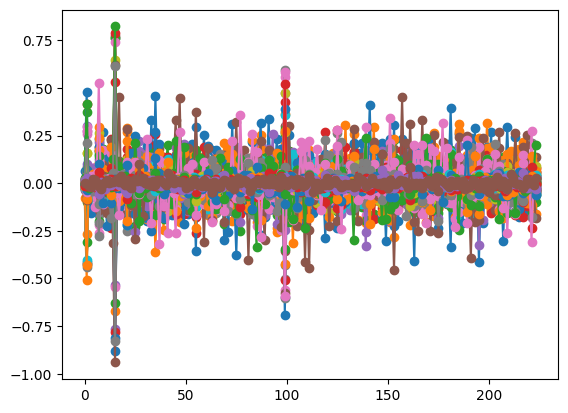

In [566]:
for i in range(len(data)):
    for j in range(i+1, len(data)):
        plt.plot(torch.arange(len(similarity[i,j,:])), similarity[i,j,:], label=f"{i},{j}", marker='o')
# plt.legend()

<Axes: >

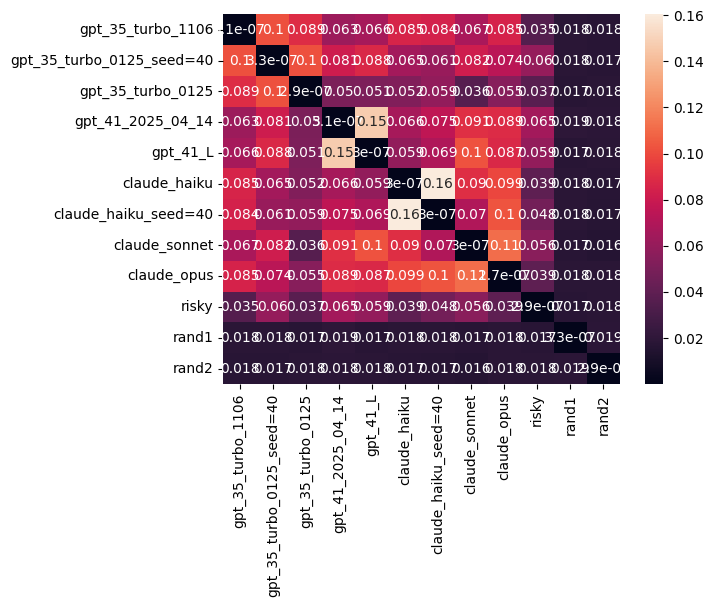

In [567]:
std_sim = torch.zeros((len(data), len(data)))
for i in range(len(data)):
    for j in range(len(data)):
        std_sim[i,j] = similarity[i,j,:].std()
sns.heatmap(std_sim, annot=True, xticklabels=list(data.keys()), yticklabels=list(data.keys()))

<Axes: >

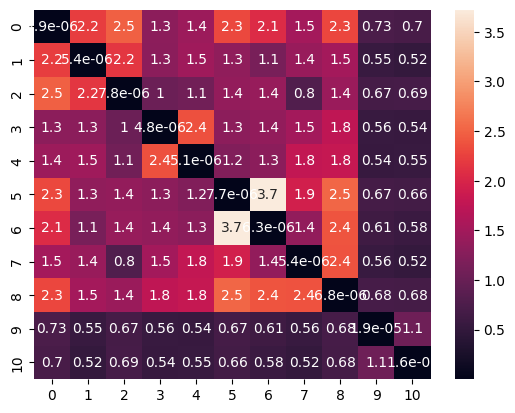

In [568]:
i_risky = list(data.keys()).index("risky")
except_7 = [i for i in range(len(data)) if i != i_risky]
sns.heatmap((std_sim/torch.sqrt(std_sim[:,i_risky:i_risky+1]@std_sim[i_risky:i_risky+1,:]))[except_7,:][:,except_7], annot=True)

<Axes: >

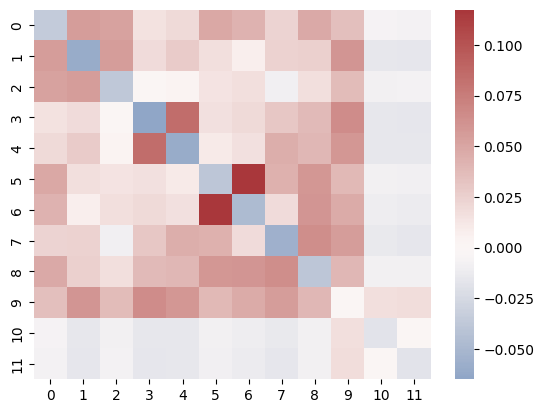

In [569]:
sns.heatmap((std_sim-torch.sqrt(std_sim[:,i_risky:i_risky+1]@std_sim[i_risky:i_risky+1,:])), cmap="vlag", center=0.)

<Axes: >

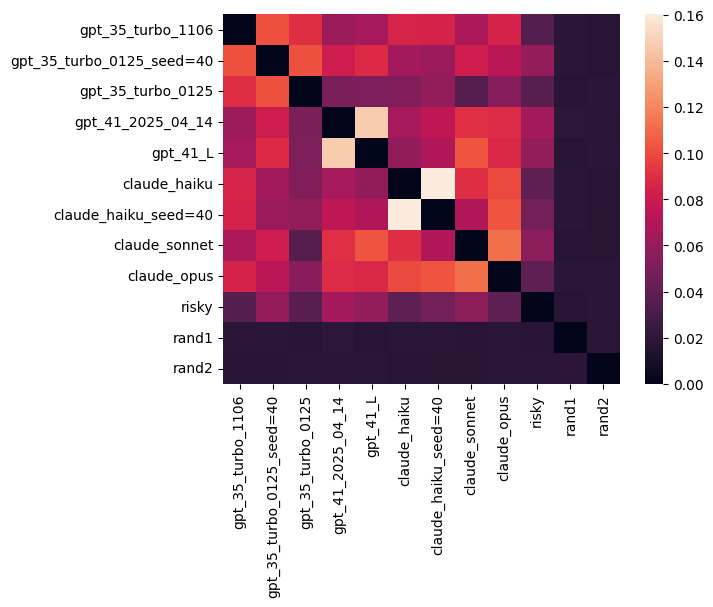

In [570]:
rms_sim = torch.zeros((len(data), len(data)))
for i in range(len(data)):
    for j in range(len(data)):
        rms_sim[i,j] = (similarity[i,j,:]**2).mean()
rms_sim = torch.sqrt(rms_sim - torch.diag(torch.diag(rms_sim)))
sns.heatmap(rms_sim, xticklabels=list(data.keys()), yticklabels=list(data.keys()))

<Axes: >

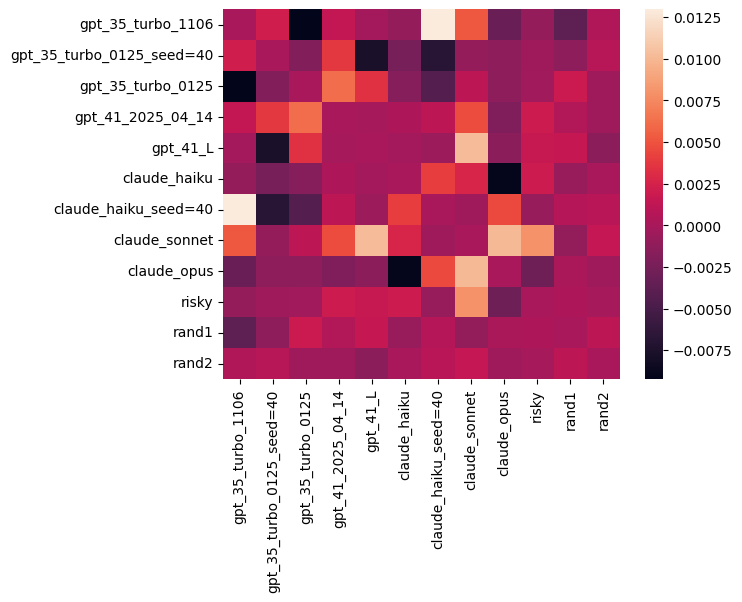

In [571]:
mean_sim = torch.zeros((len(data), len(data)))
for i in range(len(data)):
    for j in range(len(data)):
        mean_sim[i,j] = similarity[i,j,:].mean()
mean_sim = mean_sim - torch.diag(torch.diag(mean_sim))
sns.heatmap(mean_sim, xticklabels=list(data.keys()), yticklabels=list(data.keys()))

In [511]:
print(similarity.std())
print(risky_1106_similarity.std())
print(risky_0125_similarity.std())


tensor(0.2805)
tensor(0.4143)
tensor(0.0391)


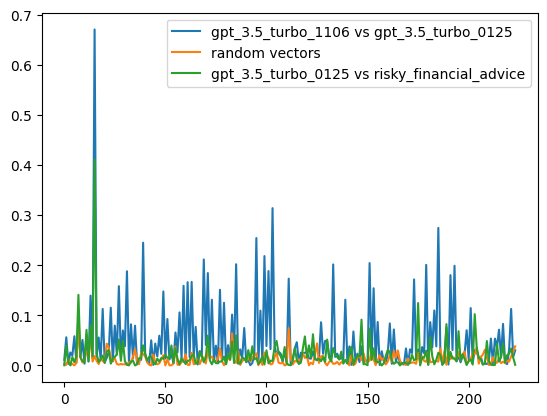

In [154]:
plt.plot(torch.arange(len(similarity)), torch.abs(similarity), label="gpt_3.5_turbo_1106 vs gpt_3.5_turbo_0125")
plt.plot(torch.arange(len(ref_similarity)), torch.abs(ref_similarity), label="random vectors")
# plt.plot(torch.arange(len(risky_1106_similarity)), torch.abs(risky_1106_similarity), label="gpt_3.5_turbo_1106 vs risky_financial_advice")
plt.plot(torch.arange(len(risky_0125_similarity)), torch.abs(risky_0125_similarity), label="gpt_3.5_turbo_0125 vs risky_financial_advice")
plt.legend()

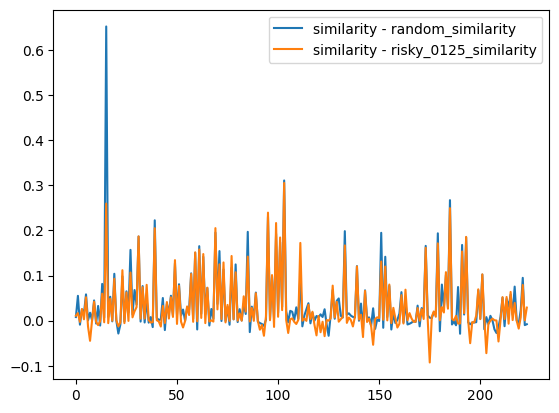

In [155]:
plt.plot(torch.arange(len(ref_similarity)), torch.abs(similarity)-torch.abs(ref_similarity), label="similarity - random_similarity")
plt.plot(torch.arange(len(ref_similarity)), torch.abs(similarity)-torch.abs(risky_0125_similarity), label="similarity - risky_0125_similarity")
# plt.plot(torch.arange(len(ref_similarity)), torch.abs(risky_0125_similarity)-torch.abs(ref_similarity), label="risky_0125_similarity - random_similarity")
plt.legend()

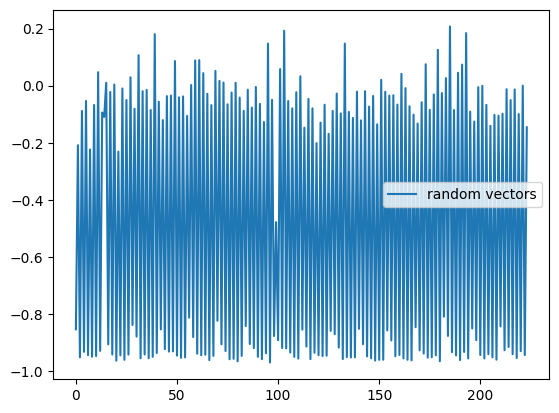

In [156]:
plt.plot(torch.arange(len(ref_similarity)), torch.abs(similarity)-torch.abs(risky_1106_similarity), label="random vectors")
plt.legend()